In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.028478 -0.055914 -0.329199 -0.506893 -0.415522  0.232138  0.360066   
  1   0.588846  0.166461  0.211363 -0.746606  1.175858  0.092420  0.179175   
  2   0.561774  0.496439 -0.331897  0.519143 -0.179823  1.297586 -0.221126   
  3  -0.580099 -0.339656  0.003086 -0.138997 -0.103888 -0.345887 -0.579852   
  4   0.208988  0.286229 -0.097217 -0.752424 -0.753570 -0.283095 -0.476042   
  5  -0.164287  0.571658  0.079340 -0.452137  0.757673  0.511898 -0.430003   
  6   0.980615  0.105198 -0.111131 -0.154249 -0.152034  0.131042 -0.002375   
  7  -0.568905 -1.372431 -0.909320 -0.375598 -1.285648 -0.080643 -0.527871   
  8   0.398337  0.642257  0.342992  1.038416 -0.186675  0.542442  0.324954   
  9  -0.091640  0.344530 -0.936431  0.198793  0.026710  1.230850 -0.261850   
  10 -0.747694 -0.672311 -1.135491 -0.391466 -0.407482 -0.006004 -0.373581   
  11 -0.039364 -0.747140 -0.661532 -0.912645 -0.568808  0.464920 -0.618366   
  12 -0.662065 -0.032344 -0.236901  0.120047 -0.107791 -0.009961  0.529286   
  13  0.424271 -0.726233 -0.595467  0.947738  0.165023  1.329981 -1.104159   
  14 -0.366291  0.234526 -0.125931  0.424341  0.561943  0.185516 -0.444604   
  15 -0.225554  0.097799 -0.104610 -0.538972 -0.631908  0.049317 -0.239599   
  16 -0.035119 -0.047360 -0.810275 -0.170057  0.184431  1.104427  0.823944   
  17  0.096762  0.087450 -0.017738  0.456125  0.630169 -0.137514 -0.770149   
  18 -0.642670 -1.020815 -0.137475  0.241378 -0.389147 -0.181551 -0.563469   
  19 -0.731683 -1.350989 -1.449522 -0.742493 -0.410709  0.537576 -0.105853   
  20  1.582451 -0.616731 -0.947807 -0.547909 -0.969519 -0.931232 -0.507453   
  21 -0.560090 -1.058854 -1.592850 -0.079065  0.575366 -0.837972 -1.725688   
  22  0.529945  0.307851 -0.230870 -0.370352  0.384817  0.485299  0.197100   
  23 -0.001991 -0.622170 -1.024392 -0.860221 -1.002167 -0.376059 -0.792736   
  24 -0.065390 -0.145665 -0.491058  0.430400  0.450571  0.822042 -0.530676   
1 0  -0.663806 -0.189756 -0.017447  0.131719  0.645401  0.045764 -0.337126   
  1  -0.084498  0.156147  0.153459  0.432969  0.621437  0.437004  0.891404   
  2  -0.695808 -0.212217  0.086401  0.683205  0.755567  0.310872 -0.325958   
  3  -0.527047 -0.513517 -0.299591  0.650587 -0.078261  1.462480  0.366345   
  4   0.101466  0.672342  0.239872 -0.041227  0.162001  0.777704 -0.149471   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.207330  0.611260 -0.540046  ...  1.254694  0.624753  1.010213   
  1   0.588347  0.053115  0.317231  ...  0.361974 -0.086026 -0.217512   
  2   0.640016  0.266578  0.235470  ... -0.574412 -0.300289 -0.269862   
  3   0.225441  0.888707  0.432691  ... -0.085414 -0.380166 -0.040851   
  4   0.251400  0.027875  0.109430  ...  0.278202  0.355496 -0.560152   
  5  -0.535022  0.678661 -0.138165  ... -0.424004  0.048846 -0.068534   
  6  -0.648352 -0.688694  0.654115  ... -0.009874  0.910696  0.207875   
  7  -1.912490  0.733263  0.264421  ... -0.894647 -1.016770  0.678092   
  8  -1.167439 -0.072293  0.089264  ... -0.887326  0.525790 -0.107243   
  9  -0.790509  0.893458 -1.044700  ...  0.282851  0.531843  0.201238   
  10 -0.447467  0.670465  0.911933  ... -0.090227 -0.342612 -0.153199   
  11 -0.400039  0.402970 -0.170111  ... -0.400249  0.001945 -0.416509   
  12  0.527588 -0.733088 -0.383260  ... -0.033784  0.291622  0.597240   
  13 -0.553110  0.345014  0.283266  ...  1.297961  0.313623  0.621671   
  14 -0.803659 -0.121536  0.043231  ...  1.038764  0.348883  0.367051   
  15 -0.585120  0.781904  0.847279  ...  0.250102  0.949264  1.125913   
  16  0.355057  0.939862 -0.069830  ...  0.826044  0.064529 -0.004434   
  17 -0.925200  0.572507  1.091026  ... -0.623889 -0.001276 -0.400129   
  18 -0.422319  0.134953 -0.621975  ... -0.442412 -0.276020  0.463290   
  19 -0.409963  0.354131 -0.235388  ... -1.152733 -0.028281 -0.464851   
  20 -0.460562 -0.494635  0.324035  ... -0.828024  0.900807 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.037209  0.040957  25.324121  1.732987e-141  0.956934  1.117484


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



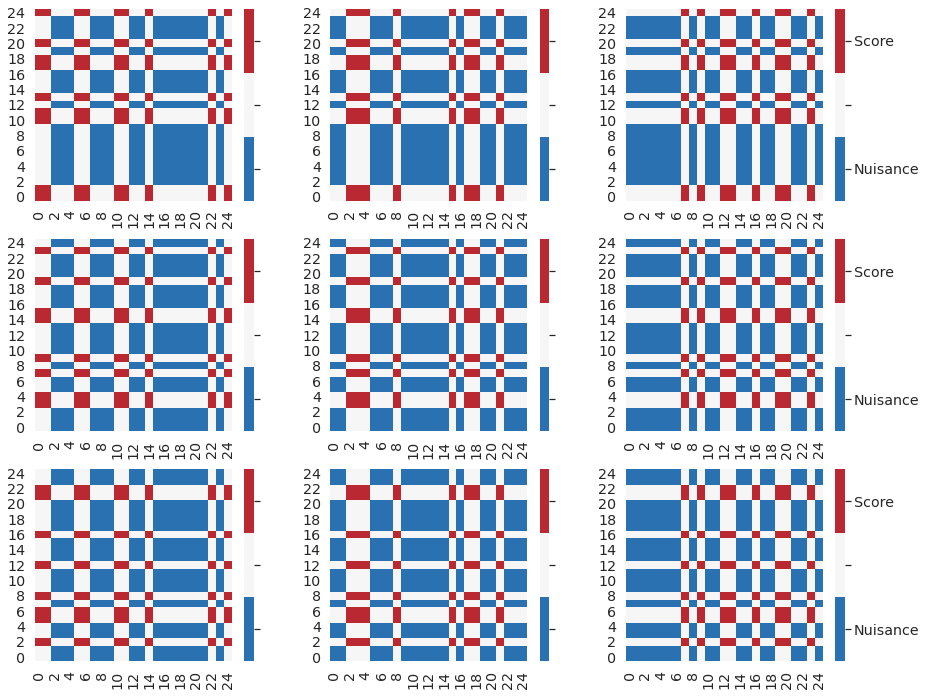

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



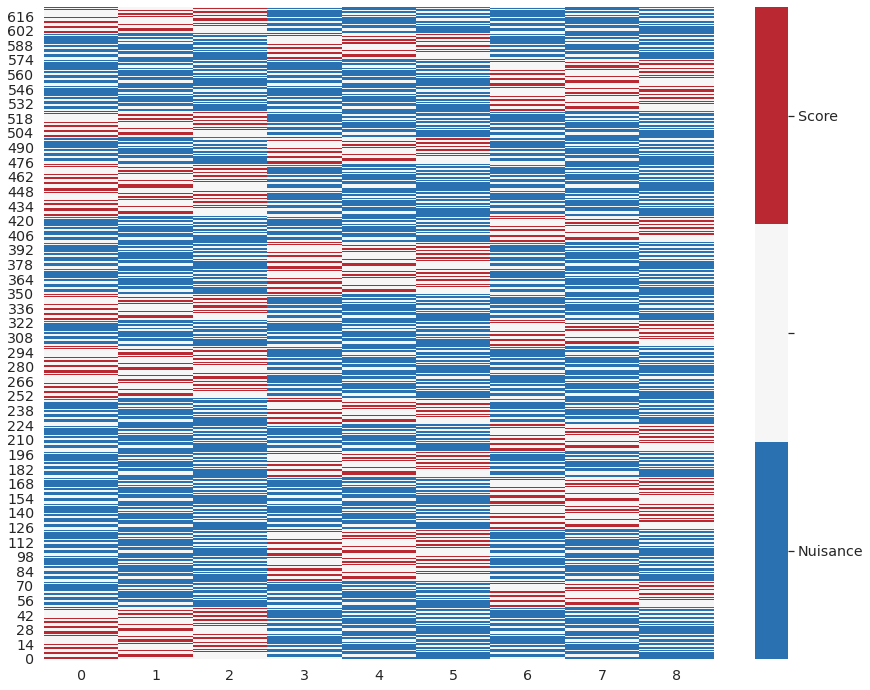

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])